In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

In [24]:
bank=pd.read_excel("/content/drive/MyDrive/Imarticus/PGA44/Decision_tree/bank.xlsx", sheet_name="bank")

In [25]:
bank["job"]=bank["job"].replace(["unemployed", "student", "retired"], "Not_earning")
bank["job"]=bank["job"].replace(["housemaid", "services", "admin."], "pink_collar")
bank["job"]=bank["job"].replace(["self-employed", "entrepreneur"], "Self_earning")

In [26]:
bank.drop(columns=["month"], inplace=True)

In [27]:
bank["deposit"]=bank["deposit"].map({"yes":1, "no":0})

In [28]:
# Outlier capping
def Outliers(x):
  x=x.clip(upper=x.quantile(.99))
  x=x.clip(lower=x.quantile(.01))
  return x

In [29]:
num=bank.select_dtypes("int").apply(Outliers)  # outlier treatment done

In [30]:
# num
ob=bank.select_dtypes("object")

In [31]:
bank_data=pd.concat([num, ob], axis=1)

In [32]:
final_data=pd.get_dummies(bank_data,
                          columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','poutcome'],
                          drop_first=True)

In [33]:
final_data.shape

(11162, 27)

In [34]:
# Model
y=final_data["deposit"]
x=final_data.drop(columns=["deposit"])
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=.3, random_state=0)

In [35]:
params={"criterion":["gini", "entropy"],
             "max_depth":[5,7,9,10, 11, 15, 17,19, 20],
             "min_samples_split":[10,50,100,150, 200],
             "min_samples_leaf":[2,5,10,50, 70, 100, 150]}

dt2=DecisionTreeClassifier(random_state=0)

gserach_dt=GridSearchCV(estimator=dt2,
                        param_grid=params,
                        cv=10, n_jobs=-1, verbose=1
                        )
gserach_dt.fit(x_train, y_train)

Fitting 10 folds for each of 630 candidates, totalling 6300 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 9, 10, 11, 15, 17, 19, 20],
                         'min_samples_leaf': [2, 5, 10, 50, 70, 100, 150],
                         'min_samples_split': [10, 50, 100, 150, 200]},
             verbose=1)

In [36]:
gserach_dt.best_params_  # Best parameters

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 200}

In [37]:
gserach_dt.best_params_["criterion"]

'entropy'

In [38]:
dt3=DecisionTreeClassifier(criterion=gserach_dt.best_params_["criterion"],
                           max_depth=gserach_dt.best_params_["max_depth"],
                           min_samples_split=gserach_dt.best_params_["min_samples_split"],
                           min_samples_leaf=gserach_dt.best_params_["min_samples_leaf"],)

In [39]:
dt3.fit(x_train, y_train)
print("train Accuracy", dt3.score(x_train, y_train))
print("test Accuracy", dt3.score(x_test, y_test))

train Accuracy 0.8246512223217715
test Accuracy 0.8106897581367573


In [40]:
# Feature importance
d=pd.DataFrame({"features":x_train.columns, "imp":dt3.feature_importances_}).sort_values(by=["imp"], ascending=False)
selected_feat=d[d["imp"]>=.01]["features"].values


In [41]:
y=final_data["deposit"]
x=final_data[selected_feat]

In [42]:
x_train1,x_test1,y_train1, y_test1=train_test_split(x,y,test_size=.3, random_state=0)

In [43]:
dt4=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=10,
                       min_samples_split=200, random_state=0)

In [44]:
dt4.fit(x_train1, y_train1)
print("train Accuracy", dt4.score(x_train1, y_train1))
print("test Accuracy", dt4.score(x_test1, y_test1))

train Accuracy 0.8246512223217715
test Accuracy 0.8106897581367573


In [45]:
pred_train=dt4.predict(x_train1)
pred_test=dt4.predict(x_test1)


In [46]:
print(metrics.classification_report(y_train1, pred_train))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      4081
           1       0.81      0.83      0.82      3732

    accuracy                           0.82      7813
   macro avg       0.82      0.82      0.82      7813
weighted avg       0.82      0.82      0.82      7813



In [47]:
print(metrics.classification_report(y_test1, pred_test))


              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1792
           1       0.79      0.81      0.80      1557

    accuracy                           0.81      3349
   macro avg       0.81      0.81      0.81      3349
weighted avg       0.81      0.81      0.81      3349



In [48]:
metrics.roc_auc_score

<function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>

In [49]:
pred_prob=pd.DataFrame(dt4.predict_proba(x_train1), columns=["prob_0", "prob_1"])


In [50]:
# ROc curve
metrics
auc=metrics.roc_auc_score(y_train1, pred_prob["prob_1"])
auc


0.9080476264013848

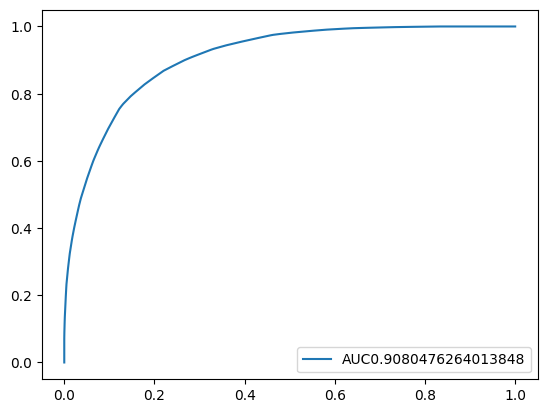

In [51]:
FPR, TPR, threshold=metrics.roc_curve(y_train1,pred_prob["prob_1"] )
auc=metrics.roc_auc_score(y_train1,pred_prob["prob_1"] )
plt.plot(FPR, TPR,label="AUC"+str(auc))
plt.legend()
plt.show()

In [52]:
import os
os.chdir("/content/drive/MyDrive/Imarticus/PGA44/Decision_tree")

In [53]:
# Saving the model for future use
from joblib import dump
dump(dt4, "dt4.joblib")

['dt4.joblib']

In [54]:
dump(selected_feat, "selected_feat.joblib")

['selected_feat.joblib']

In [55]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'deposit'],
      dtype='object')

In [ ]:
#Break Time : Come back by 12:25 pm